In [1]:
import glob
import pandas as pd
import json
import pickle as pkl

import numpy as np
import matplotlib.pyplot as plt
import hist
import mplhep
import matplotlib as mpl
from matplotlib.lines import Line2D

mpl.rcParams["font.size"] = 16
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["grid.color"] = "#CCCCCC"
mpl.rcParams["grid.linewidth"] = 0.5
mpl.rcParams["figure.edgecolor"] = "none"

import matplotlib.ticker as mticker
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
mplhep.style.use(["CMS", "firamath"])

In [2]:
def get_sum_sumgenweight(pkl_files, year, sample):
    sum_sumgenweight = 0
    for ifile in pkl_files:
        # load and sum the sumgenweight of each
        with open(ifile, "rb") as f:
            metadata = pkl.load(f)
        sum_sumgenweight = sum_sumgenweight + metadata[sample][year]["sumgenweight"]
    return sum_sumgenweight

def get_xsecweight(pkl_files, year, sample, is_data, luminosity):
    if not is_data:
        # find xsection
        f = open("../fileset/xsec_pfnano.json")
        xsec = json.load(f)
        f.close()
        try:
            xsec = eval(str((xsec[sample])))
        except ValueError:
            print(f"sample {sample} doesn't have xsecs defined in xsec_pfnano.json so will skip it")
            return None

        # get overall weighting of events.. each event has a genweight...
        # sumgenweight sums over events in a chunk... sum_sumgenweight sums over chunks
        xsec_weight = (xsec * luminosity) / get_sum_sumgenweight(pkl_files, year, sample)
    else:
        xsec_weight = 1
    return xsec_weight

In [55]:
leppt_axis = hist.axis.Regular(
    50, 0, 250, name="leppt", label=r"Gen Lepton p$_T$"
)
drjet_axis = hist.axis.Regular(
    40, 0, 3, name="drjet", label=r"$\Delta$ R(Gen Lepton, AK8 Jet)"
)
sample_axis = hist.axis.StrCategory([], name="name", growth=True)
h_leppt = hist.Hist(leppt_axis, sample_axis)
h_leppt_v = hist.Hist(leppt_axis, sample_axis)
h_leppt_vs = hist.Hist(leppt_axis, sample_axis)
h_dr = hist.Hist(drjet_axis, sample_axis)
h_drleading = hist.Hist(drjet_axis, sample_axis)

odir = "/eos/uscms/store/user/cmantill/boostedhiggs/Jan16_sel_signal_2016/"
ch = "mu"
samples_dict = {
    "ggH": ["GluGluHToWW_Pt-200ToInf_M-125"],
    "VBF": ["VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil"],
    "VH": [
        "HWminusJ_HToWW_M-125",
        "HZJ_HToWW_M-125",
        "HWplusJ_HToWW_M-125",
    ],
    "ttH": ["ttHToNonbb_M125"],
}
year = "2016"

for key,samples in samples_dict.items():
    for sample in samples:
        parquet_files = glob.glob(f"{odir}/{sample}/outfiles/*_{ch}.parquet")
        pkl_files = glob.glob(f"{odir}/{sample}/outfiles/*.pkl")

        data = pd.read_parquet(parquet_files, columns=["fj_H_VV_isMatched", "fj_genH_pt", "fj_H_VV_isVlepton", "fj_H_VV_isVstarlepton", "gen_Vlep_pt", "genlep_dR_fj", "genlep_dR_fjpt", f"weight_{ch}"])

        luminosity = 137640.0

        event_weight = get_xsecweight(pkl_files, year, sample, False, luminosity)
        event_weight *= data[f"weight_{ch}"]

        selection = (data["fj_genH_pt"] > 200) & (data["fj_H_VV_isMatched"] == 1)
        data = data[selection]
        event_weight = event_weight[selection]

        h_leppt.fill(data["gen_Vlep_pt"].values, key, weight=event_weight)
        h_leppt_v.fill(data[data["fj_H_VV_isVlepton"]==1]["gen_Vlep_pt"].values, key, weight=event_weight[data["fj_H_VV_isVlepton"]==1])
        h_leppt_vs.fill(data[data["fj_H_VV_isVstarlepton"]==1]["gen_Vlep_pt"].values, key, weight=event_weight[data["fj_H_VV_isVstarlepton"]==1])

        h_dr.fill(data["genlep_dR_fj"].values, key, weight=event_weight)
        h_drleading.fill(data["genlep_dR_fjpt"], key, weight=event_weight)

In [56]:
data["fj_H_VV_isVlepton"]

75          None
89          None
121         True
208        False
226         True
           ...  
1142103     None
1142139     True
1142183     True
1142218     True
1142226    False
Name: fj_H_VV_isVlepton, Length: 39869, dtype: object

In [57]:
data["fj_H_VV_isVstarlepton"]

75          None
89          None
121        False
208         True
226        False
           ...  
1142103     None
1142139    False
1142183    False
1142218    False
1142226     True
Name: fj_H_VV_isVstarlepton, Length: 39869, dtype: object

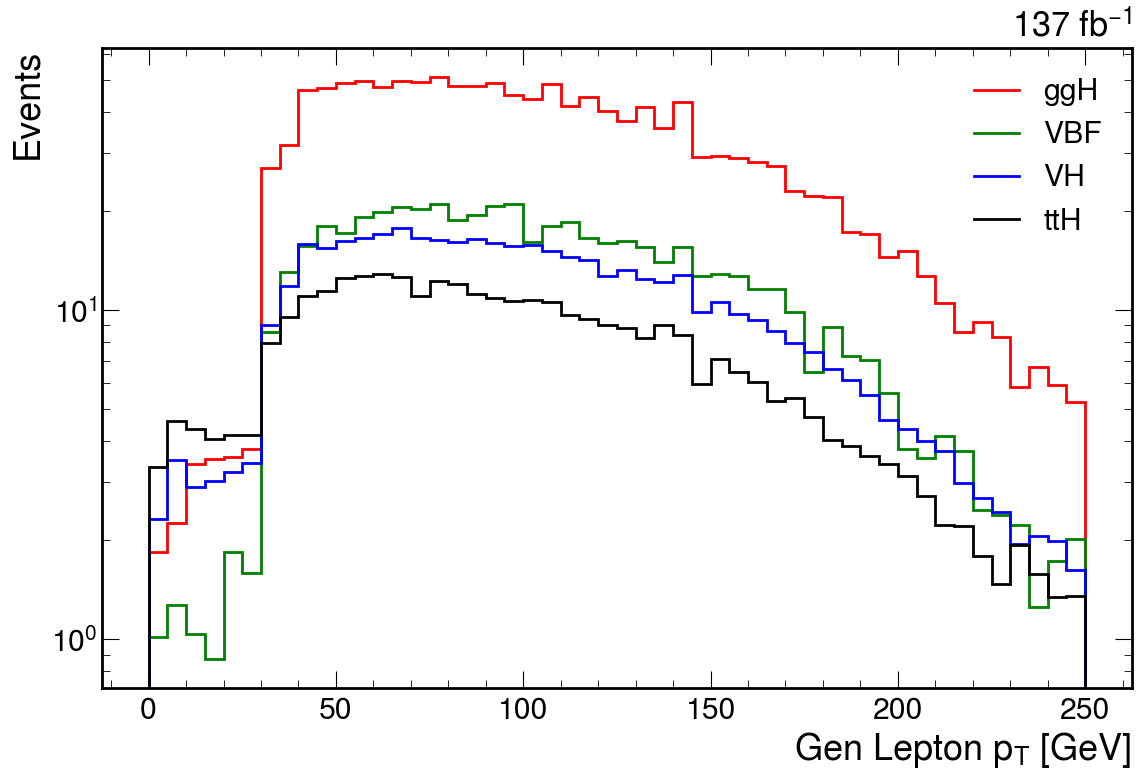

In [61]:
fig, ax = plt.subplots(figsize=(12, 8))
legend_elements = []
color_by_sample = {
    "ggH": "red",
    "VBF": "green",
    "VH": "blue",
    "ttH": "black",
}
for key in color_by_sample.keys():
    mplhep.histplot(
        h_leppt[{"name": key}],
        lw=2,
        #density=True,
        color=color_by_sample[key],
        flow="none"
    )
    legend_elements.append(
        Line2D([0], [0], color=color_by_sample[key], lw=2, label=key)
    )
ax.set_yscale("log")
ax.legend(handles=legend_elements)
ax.set_ylabel("Events")
ax.set_xlabel(r"Gen Lepton p$_T$ [GeV]")
plt.tight_layout()
mplhep.cms.lumitext(r"137 fb$^{-1}$")
fig.savefig("leppt_gen.png")


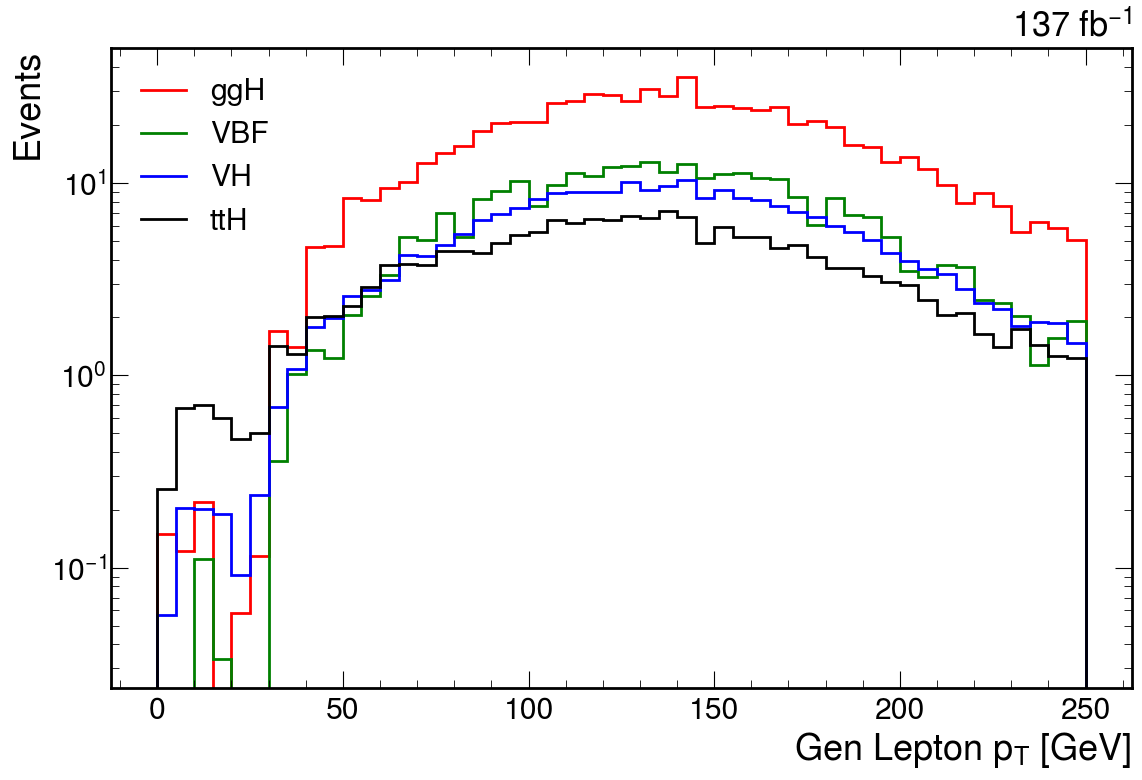

In [62]:
fig, ax = plt.subplots(figsize=(12, 8))
legend_elements = []
color_by_sample = {
    "ggH": "red",
    "VBF": "green",
    "VH": "blue",
    "ttH": "black",
}
for key in color_by_sample.keys():
    mplhep.histplot(
        h_leppt_v[{"name": key}],
        lw=2,
        #density=True,
        color=color_by_sample[key],
        flow="none"
    )
    legend_elements.append(
        Line2D([0], [0], color=color_by_sample[key], lw=2, label=key)
    )
ax.set_yscale("log")
ax.legend(handles=legend_elements)
ax.set_ylabel("Events")
ax.set_xlabel(r"Gen Lepton p$_T$ [GeV]")
plt.tight_layout()
mplhep.cms.lumitext(r"137 fb$^{-1}$")
fig.savefig("leppt_gen_fromV.png")

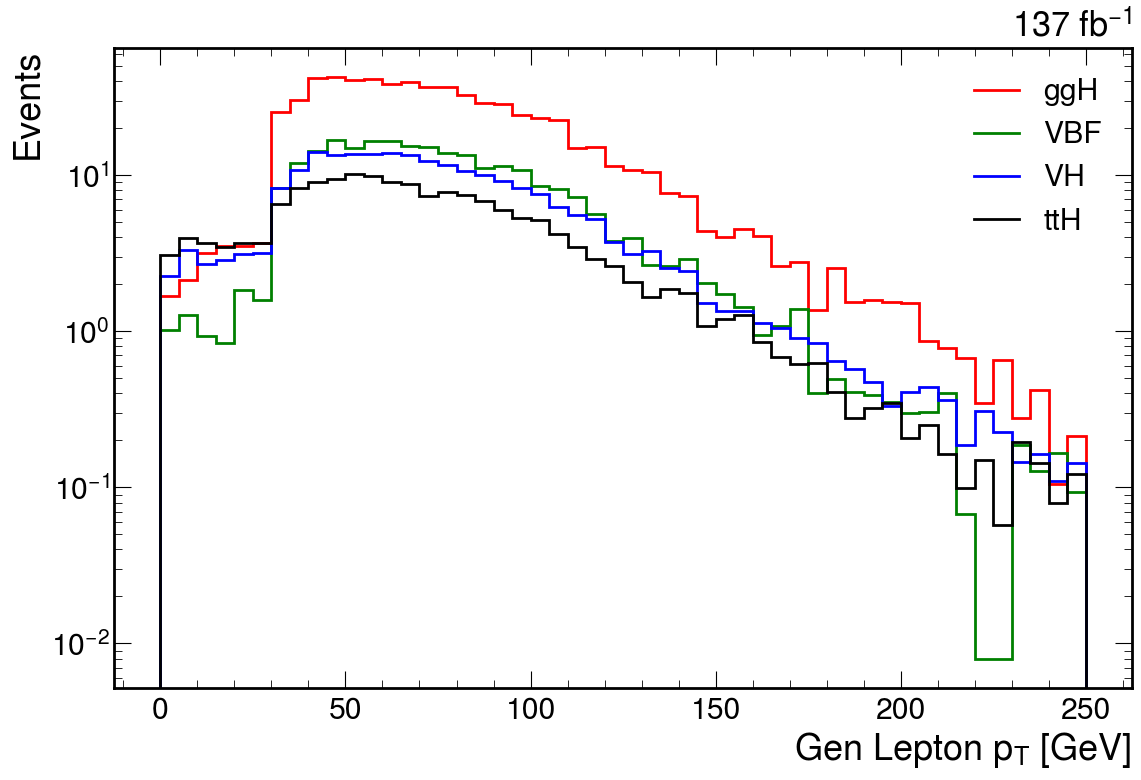

In [63]:
fig, ax = plt.subplots(figsize=(12, 8))
legend_elements = []
color_by_sample = {
    "ggH": "red",
    "VBF": "green",
    "VH": "blue",
    "ttH": "black",
}
for key in color_by_sample.keys():
    mplhep.histplot(
        h_leppt_vs[{"name": key}],
        lw=2,
        #density=True,
        color=color_by_sample[key],
        flow="none"
    )
    legend_elements.append(
        Line2D([0], [0], color=color_by_sample[key], lw=2, label=key)
    )
ax.set_yscale("log")
ax.legend(handles=legend_elements)
ax.set_ylabel("Events")
ax.set_xlabel(r"Gen Lepton p$_T$ [GeV]")
plt.tight_layout()
mplhep.cms.lumitext(r"137 fb$^{-1}$")
fig.savefig("leppt_gen_fromVs.png")

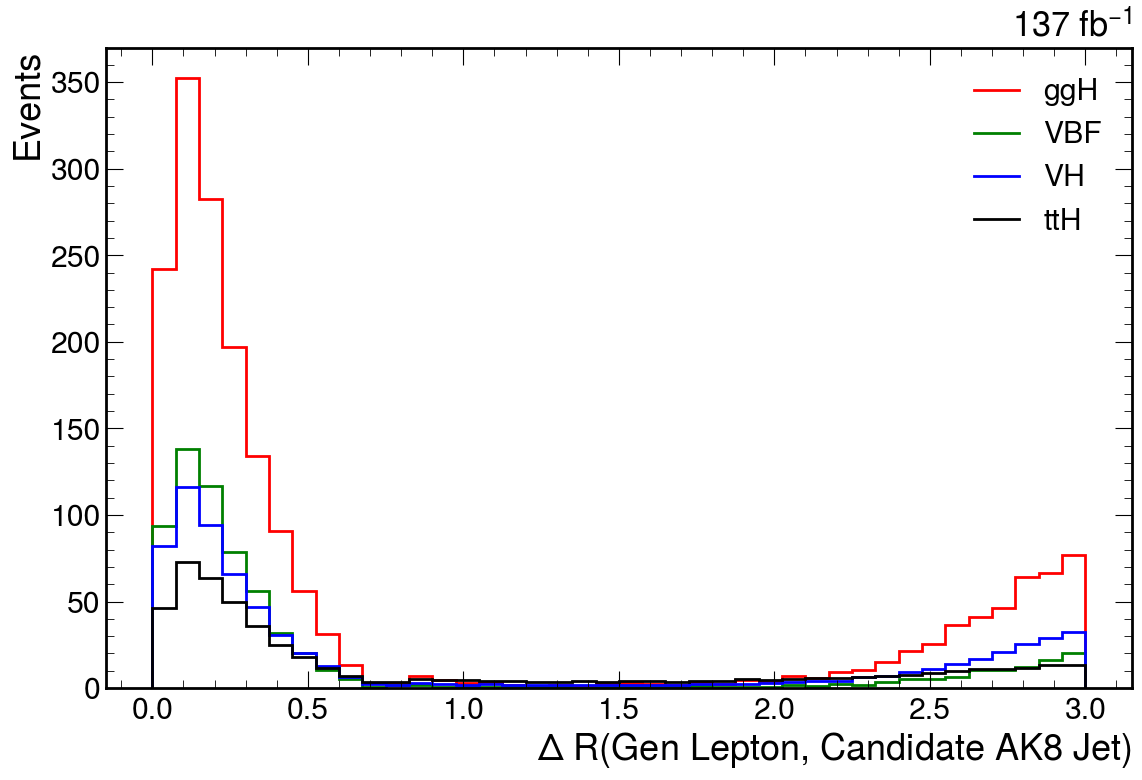

In [37]:
fig, ax = plt.subplots(figsize=(12, 8))
legend_elements = []
color_by_sample = {
    "ggH": "red",
    "VBF": "green",
    "VH": "blue",
    "ttH": "black",
}
for key in color_by_sample.keys():
    mplhep.histplot(
        h_dr[{"name": key}],
        lw=2,
        #density=True,
        color=color_by_sample[key],
        flow="none"
    )
    legend_elements.append(
        Line2D([0], [0], color=color_by_sample[key], lw=2, label=key)
    )
#ax.set_yscale("log")
ax.legend(handles=legend_elements)
ax.set_xlabel(r"$\Delta$ R(Gen Lepton, Candidate AK8 Jet)")
ax.set_ylabel("Events")
plt.tight_layout()
mplhep.cms.lumitext(r"137 fb$^{-1}$")
fig.savefig("lepdr_gen.png")

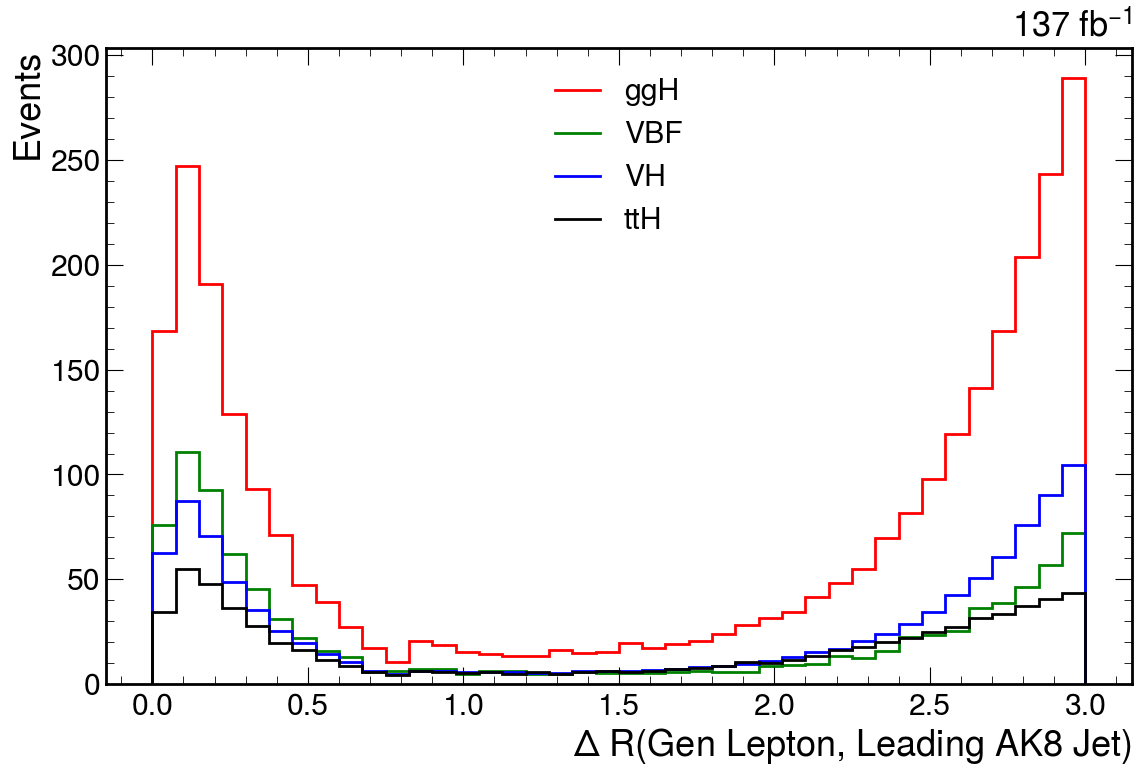

In [36]:
fig, ax = plt.subplots(figsize=(12, 8))
legend_elements = []
color_by_sample = {
    "ggH": "red",
    "VBF": "green",
    "VH": "blue",
    "ttH": "black",
}
for key in color_by_sample.keys():
    mplhep.histplot(
        h_drleading[{"name": key}],
        lw=2,
        #density=True,
        color=color_by_sample[key],
        flow="none"
    )
    legend_elements.append(
        Line2D([0], [0], color=color_by_sample[key], lw=2, label=key)
    )
# ax.set_yscale("log")
ax.legend(handles=legend_elements)
ax.set_xlabel(r"$\Delta$ R(Gen Lepton, Leading AK8 Jet)")
ax.set_ylabel("Events")
plt.tight_layout()
mplhep.cms.lumitext(r"137 fb$^{-1}$")
fig.savefig("lepdr-leading_gen.png")